# Navigation

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 2.0.10 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below.  Please run the next code cell without making any changes.

In [2]:
from unityagents import UnityEnvironment
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import matplotlib.pyplot as plt
from collections import deque,namedtuple

In [3]:

# please do not modify the line below
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agent while it is training**, and you should set `train_mode=True` to restart the environment.

In [6]:
env_info = env.reset(train_mode=True)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 1.0


When finished, you can close the environment.

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agent while it is training.  However, **_after training the agent_**, you can download the saved model weights to watch the agent on your own machine! 

In [7]:
GAMMA = .995
TAU = 1e-3
LR = 5e-4
BUFFER_SIZE = int(1e5)
BATCH_SIZE = 64
SEED = 0
UPDATE_EVERY = 4
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  

In [8]:
class Agent:
    def __init__(self,state_size,action_size,seed = 0,implement = 'DDQN',implement_1 = 'Duelling'):
        
        self.state_size = state_size
        self.action_size = action_size
        self.implement = implement
        self.seed = random.seed(seed)
        
        if implement_1 == 'Duelling':
            self.local_net = DuellingQNetwork(state_size,action_size,SEED).to(device)
            self.target_net = DuellingQNetwork(state_size,action_size,SEED).to(device)
        else:
            self.local_net = QNetwork(state_size,action_size,SEED).to(device)
            self.target_net = QNetwork(state_size,action_size,SEED).to(device)
        
        self.optimizer = optim.Adam(self.local_net.parameters(),lr = LR)
        
        self.memory = ReplayBuffer(BUFFER_SIZE,BATCH_SIZE,SEED)
        self.t_steps = 0
        
    def epsilon_greedy(self,action_value,eps):
        
        gen = random.uniform(0,1)
        if gen > eps:
            return np.argmax(action_value.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
        
    def act(self, state, eps = 0.):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.local_net.eval()
        with torch.no_grad():
            action_values = self.local_net(state)
#             print('Action Values : ',action_values)
#             print('Action Values size : ',action_values.shape)
        self.local_net.train()
        return self.epsilon_greedy(action_values,eps)
    def step(self,state,action,reward,next_state,done):
        
        self.memory.add(state,action,reward,next_state,done)
        
        self.t_steps = (self.t_steps + 1)% UPDATE_EVERY
        
        if self.t_steps == 0:
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences,GAMMA)
    def learn(self,experiences,gamma):
        
        states,actions,rewards,next_states,dones = experiences
        
        if self.implement == 'DQN':
            
            targeted_values_next = self.target_net(next_states).detach().max(1)[0].unsqueeze(1)
        
        if self.implement == 'DDQN':
            
            best_action_next = self.local_net(next_states).max(1)[1].unsqueeze(1)
            target_values = self.target_net(next_states)
            targeted_values_next = torch.gather(target_values,1,best_action_next)
        
        target_total = rewards + (gamma*targeted_values_next*(1-dones))
        local_estimate = self.local_net(states).gather(1,actions)
        
        loss = F.mse_loss(local_estimate,target_total)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        #Update target network parameters
        self.update(self.local_net,self.target_net,TAU)
    
    def update(self,local_net,target_net,tau):
        for local_param,target_param in zip(local_net.parameters(),target_net.parameters()):
            target_param.data.copy_(local_param*tau + (1-tau)*target_param)


In [9]:
class QNetwork(nn.Module):
    def __init__(self,state_size,action_size,seed,fc1_units = 64,fc2_units = 64):
        super(QNetwork,self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc_1 = nn.Linear(state_size,fc1_units)
        self.fc_2 = nn.Linear(fc1_units,fc2_units)
        self.fc_3 = nn.Linear(fc2_units,action_size)
    
    def forward(self,state):
        x = F.relu(self.fc_1(state))
        x = F.relu(self.fc_2(x))
        x = self.fc_3(x)
        return x

In [10]:
class DuellingQNetwork(nn.Module):
    def __init__(self,state_size,action_size,seed,fc1_units = 64,fc2_units = 64):
        super(DuellingQNetwork,self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc_1 = nn.Linear(state_size,fc1_units)
        self.fc_2 = nn.Linear(fc1_units,fc2_units)
        self.action_size = action_size
        self.action_fc = nn.Linear(fc2_units,action_size)
        self.value_fc = nn.Linear(fc2_units,1)
    
    def forward(self,state):
        x = F.relu(self.fc_1(state))
        x = F.relu(self.fc_2(x))
        
        action_value = self.action_fc(x)
        value_value = self.value_fc(x)
        
        return value_value + action_value - action_value.mean(dim = 1,keepdim = True).expand(x.size(0),self.action_size)

In [11]:
class ReplayBuffer:
    def __init__(self,buffer_size,batch_size,seed):
        
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.seed = random.seed(seed)
        self.memory = deque(maxlen = buffer_size)
        self.experience = namedtuple('Experiences',field_names = ['state','action','reward','next_state','done'])
    
    def add(self,state,action,reward,next_state,done):
        e = self.experience(state,action,reward,next_state,done)
        self.memory.append(e)
    
    def sample(self):
        
        experience = random.sample(self.memory, k = self.batch_size)
        
        states = torch.from_numpy(np.vstack([e.state for e in experience if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experience if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experience if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experience if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experience if e is not None]).astype(np.uint8)).float().to(device)
        
        return (states,actions,rewards,next_states,dones)
    
    def __len__(self):
        return len(self.memory)
    

In [12]:
agent = Agent(state_size = 37,action_size = 4,seed = 0,implement = 'DDQN',implement_1 = 'noduelling')

In [13]:
env_info = env.reset(train_mode = True)[brain_name]
state = env_info.vector_observations[0]
score = 0
for j in range(200):
    print(state)
    action = agent.act(state)
    #state, reward, done, _ = env.step(action)
    env_info = env.step(action)[brain_name] 
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]
    state = next_state
    score += reward
    if done:
        break 
print('Score : ',score)
        

[ 1.          0.          0.          0.          0.71256876  0.          0.
  1.          0.          0.73509979  0.          0.          0.          1.
  0.          1.          0.          0.          0.          0.31326672
  0.          0.          1.          0.          0.58369923  0.          0.
  0.          1.          0.          1.          0.          0.          0.
  0.23518428  0.          0.        ]
[  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   1.00000000e+00   0.00000000e+00   8.89842510e-01   1.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.12501872e-01
   0.00000000e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
   5.98857522e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   1.00000000e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
   0.00000000e+00   0.0000000

Episode 100 	Average score:  0.12
Episode 200 	Average score:  0.60
Episode 300 	Average score:  1.41
Episode 400 	Average score:  2.41
Episode 500 	Average score:  3.38
Episode 600 	Average score:  4.42
Episode 700 	Average score:  5.54
Episode 800 	Average score:  6.32
Episode 900 	Average score:  6.93
Episode 1000 	Average score:  8.03
Episode 1100 	Average score:  8.51
Episode 1200 	Average score:  8.73
Episode 1300 	Average score:  10.58
Episode 1400 	Average score:  10.51
Episode 1500 	Average score:  10.47
Episode 1600 	Average score:  10.40
Episode 1700 	Average score:  11.23
Episode 1800 	Average score:  11.19
Episode 1900 	Average score:  12.56
Episode 1936 	Average score:  13.00
Environment solved in  1836 episodes!	Average Score:  13.00


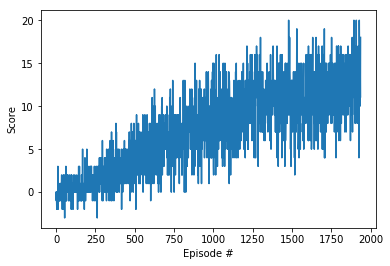

In [14]:
def DDQN(num_episodes = 3000,max_t = 1000,eps_start = 1.0,eps_min = .01,eps_decay = .999,window = 100):
    scores = []
    window_score = deque(maxlen = window)
    eps = eps_start
    for i_episode in range(1,num_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]     # reset the environment
        state = env_info.vector_observations[0]               # get the initial state
        score = 0  
        
        for t in range(max_t):
            action = agent.act(state, eps)                    # select the action
            env_info = env.step(action)[brain_name] 
            next_state = env_info.vector_observations[0]      # get the state
            reward = env_info.rewards[0]                      # get the reward
            done = env_info.local_done[0]   
            agent.step(state, action, reward, next_state, done)  # train the agent 
            score += reward
            state = next_state
            if done:
                break
        window_score.append(score)
        scores.append(score)
        eps = max(eps_min, eps * eps_decay)        # modify epsilon
        average_score = np.mean(window_score)
        print('\rEpisode {} \tAverage score: {: .2f}'.format(i_episode, average_score), end="")
        
        if i_episode % 100 == 0:
            print('\rEpisode {} \tAverage score: {: .2f}'.format(i_episode, average_score))
            
        if average_score >= 13 and i_episode==3000:      # check if environment is solved
            print('\nEnvironment solved in {: d} episodes!\tAverage Score: {: .2f}'.format(i_episode - 100, average_score))
            torch.save(agent.local_net.state_dict(), 'checkpoint_ddqn.pth')
            break
    
    return scores

scores = DDQN()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score') 

plt.xlabel('Episode #')
plt.show()